<a href="https://colab.research.google.com/github/jo1jun/Vision_Transformer/blob/main/VisualizeAttentionMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import, device & dtype


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import matplotlib.pyplot as plt
import os
import copy

# tensorboard writer
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.long

# Use einops moudule
# reference & tutorial: http://einops.rocks/pytorch-examples.html
!pip install einops
from einops import rearrange, repeat, reduce
from einops.layers.torch import Rearrange

# WarmupCosineSchedule
!pip install pytorch_transformers
from pytorch_transformers.optimization import WarmupCosineSchedule

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 145.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.3 MB/s eta 0:00:00


In [2]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, d_model, nhead, dropout_ratio):
        super().__init__()

        self.d_model = d_model  # d_model: embed dimension
        self.nhead = nhead  # nhead: number of head
        self.head_dim = d_model // nhead  # head_dim: dimension per head

        # Query(Q), Key(K), Value(V)
        self.qLinear = nn.Linear(d_model, d_model) # query lineqr
        self.kLinear = nn.Linear(d_model, d_model) # key linear
        self.vLinear = nn.Linear(d_model, d_model) # value linear

        self.oLinear = nn.Linear(d_model, d_model) # output linear
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, query, key, value):
        # query: [batch_size, query_len, d_model]
        # key: [batch_size, key_len, d_model]
        # value: [batch_size, value_len, d_model]
        batch_size = query.shape[0]
        query_len = query.shape[1]
        key_len = key.shape[1]
        value_len = key.shape[1]

        Q = self.qLinear(query)  # [batch_size, query_len, d_model]
        K = self.kLinear(key)  # [batch_size, key_len, d_model]
        V = self.vLinear(value)  # [batch_size, value_len, d_model]

        # d_model = nhead * head_dim
        Q = rearrange(Q, 'b l (h d) -> b h l d', h=self.nhead)  # [batch_size, query_len, d_model] -> [batch_size, nhead, query_len, head_dim]
        K = rearrange(K, 'b l (h d) -> b h l d', h=self.nhead)  # [batch_size, key_len, d_model] -> [batch_size, nhead, key_len, head_dim]
        V = rearrange(V, 'b l (h d) -> b h l d', h=self.nhead)  # [batch_size, value_len, d_model] -> [batch_size, nhead, value_len, head_dim]

        #=========Scaled Dot-Product Attention=========
        # attention score
        score = torch.matmul(Q, rearrange(K, 'b h l d -> b h d l')) / np.sqrt(self.head_dim)  # weight: [batch_size, nhead, query_len, key_len]

        # attention weight
        weight = torch.softmax(score, dim=-1)  # [batch_size, nhead, query_len, key_len]

        # context vector
        # key_len == value_len
        c = torch.matmul(self.dropout(weight), V)  # [batch_size, nhead, query_len, head_dim]
        #==============================================

        # reshape & concat
        c = rearrange(c, 'b h l d -> b l (h d)')  # [batch_size, query_len, d_model]
        output = self.oLinear(c)  # [batch_size, query_len, d_model]

        return output, weight

In [3]:
class PositionWiseFeedForwardLayer(nn.Module):
    def __init__(self, d_model, ff_dim, dropout_ratio):
        super().__init__()
        # ff_dim : FFN number of hidden layer node
        self.linear1 = nn.Linear(d_model, ff_dim)
        self.linear2 = nn.Linear(ff_dim, d_model)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        # x: [batch_size, seq_len, d_model]

        # The MLP contains two layers with a GELU non-linearity
        x = self.dropout(nn.functional.gelu(self.linear1(x)))  # [batch_size, seq_len, ff_dim]
        x = self.linear2(x)  # [batch_size, seq_len, d_model]

        return x

In [4]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, ff_dim, dropout_ratio):
        super().__init__()

        self.layerNorm1 = nn.LayerNorm(d_model)
        self.layerNorm2 = nn.LayerNorm(d_model)
        self.multiHeadAttentionLayer = MultiHeadAttentionLayer(d_model, nhead, dropout_ratio)
        self.positionWiseFeedForward = PositionWiseFeedForwardLayer(d_model, ff_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src: [batch_size, src_len, d_model]
        # input --> LN --> MHA --> residual --> LN --> FFN -> residual

        # Pre-normalization
        # Layernorm (LN) is applied before every block
        _src = self.layerNorm1(src)

        # self attention --> (Q == K == V)
        _src, attention = self.multiHeadAttentionLayer(_src, _src, _src)

        # residual connections after every block
        src = src + self.dropout(_src)

        # LN --> FFN -> residual
        _src = self.layerNorm2(src)  # [batch_size, src_len, d_model]
        _src = self.positionWiseFeedForward(_src)
        src = src + self.dropout(_src)  # [batch_size, src_len, d_model]

        return src, attention

In [5]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, ff_dim, dropout_ratio):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, nhead, ff_dim, dropout_ratio) for _ in range(n_layers)])

    def forward(self, src):
        attentions = []

        for layer in self.layers:
            src, attention = layer(src)
            attentions.append(attention)

        return src, attentions

In [6]:
class ImageEmbedding(nn.Module):
  def __init__(self, channel, patch_size, D):
    super().__init__()
    # image --> patch --> [batch_size, patch_num, patch_size*patch_size*channel]
    self.rearrange = Rearrange('b c (num_w p_h) (num_h p_w) -> b (num_w num_h) (p_h p_w c) ', p_h=patch_size, p_w=patch_size)
    # [batch_size, patch_num, patch_size*patch_size*channel] -> [batch_size, patch_num, embed_dim]
    self.linear = nn.Linear(channel*patch_size*patch_size, D)
    # learnable [CLS] token
    self.cls_token = nn.Parameter(torch.randn(1, 1, D))

  def forward(self, image):
    b, c, w, h = image.shape  # image: [batch_size, channel, width, height]

    # num_w = w / p_h
    # num_h = h / p_w
    # n = num_w * num_h = (w*h) / (p_h*p_w)
    flatten_patches = self.rearrange(image)  # [batch_size, patch_num, patch_size*patch_size*channel]
    embedded_patches = self.linear(flatten_patches)  # [batch_size, patch_num, embed_dim]

    # Add [CLS] token
    cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
    embedded_patches = torch.cat((cls_tokens, embedded_patches), dim=1)  # [batch_size, 1 + patch_num, embed_dim]

    return embedded_patches


In [7]:
class TokPosEmbedding(nn.Module):
  def __init__(self, c, p, d_model, dropout_ratio):
    super().__init__()
    self.tokEmbedding = ImageEmbedding(c, p, d_model)
    self.posEmbedding = nn.Embedding(100, d_model)  # learnable positional embedding (num of max patch = 100)
    self.d_model = d_model
    self.dropout = nn.Dropout(dropout_ratio)

  def forward(self, src):

    # src: [batch_size, width, height, channel] --> [batch_size, src_len, d_model]
    # src_len = (patch num + 1)
    src = self.tokEmbedding(src)

    batch_size = src.shape[0]
    src_len = src.shape[1]

    # Generate numbers from 0 to src_len-1
    pos = torch.arange(0, src_len, dtype=dtype)  # [src_len]
    pos = repeat(pos, 'l -> b l', b=batch_size).to(device)  # [batch_size, src_len]

    src = self.dropout(src * float(np.sqrt(self.d_model)) + self.posEmbedding(pos))

    return src  # [batch_size, src_len, d_model]

In [8]:
class VisionTransformer(nn.Module):
    def __init__(self, c, p, d_model, n_layers, nhead, ff_dim, dropout_ratio, output_dim):
        super().__init__()

        self.encEmbedding = TokPosEmbedding(c, p, d_model, dropout_ratio)
        self.encoder = Encoder(d_model, n_layers, nhead, ff_dim, dropout_ratio)
        self.layerNorm = nn.LayerNorm(d_model)
        self.linear = nn.Linear(d_model, output_dim)

    def forward(self, src):
        # src: [batch_size, src_len]

        src = self.encEmbedding(src)
        enc_src, attentions = self.encoder(src)  # [batch_size, src_len, d_model]

        # classification head
        cls_token = enc_src[:,0,:]  # [batch_size, d_model]
        cls_token = self.layerNorm(cls_token)

        output = self.linear(cls_token)  # [batch_size, output_dim]

        return output, attentions

# MNIST Dataset & DataLoader

In [9]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive


In [10]:
transform = T.Compose([
                T.ToTensor(),  # data scale: 0~1
                T.Normalize((0.5), (0.5))  # data scale: -1~1
            ])

mnist_train = dset.MNIST('dataset', train=True, download=True,
                             transform=transform)
mnist_val = dset.MNIST('dataset', train=True, download=True,
                           transform=transform)
mnist_test = dset.MNIST('dataset', train=False, download=True,
                            transform=transform)

NUM_TRAIN = 50000
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
dataloaders['val'] = DataLoader(mnist_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))
dataloaders['test'] = DataLoader(mnist_test, batch_size=64)

# Trainer

In [11]:
def trainer(model_name, model, criterion, optimizer, scheduler, num_epochs):

    model.to(device)
    writer = SummaryWriter(f'runs/{model_name}')
    best_model_wts = copy.deepcopy(model.state_dict())
    global_step, best_acc = 0, 0.0
    running_loss, running_acc = {}, {}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss[phase], running_acc[phase] = 0.0, 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss[phase] += loss.item() * inputs.shape[0]
                running_acc[phase] += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            running_loss[phase] = running_loss[phase] / (len(dataloaders[phase]) * dataloaders[phase].batch_size)
            running_acc[phase] = running_acc[phase].double() / (len(dataloaders[phase]) * dataloaders[phase].batch_size)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, running_loss[phase], running_acc[phase]))

            # deep copy the model
            if phase == 'val' and running_acc[phase] > best_acc:
                best_acc = running_acc[phase]
                best_model_wts = copy.deepcopy(model.state_dict())

        writer.add_scalars(f'{model_name}/loss', {'train' : running_loss['train'], 'val' : running_loss['val']}, global_step)
        writer.add_scalars(f'{model_name}/acc', {'train' : running_acc['train'], 'val' : running_acc['val']}, global_step)
        writer.add_scalar(f'{model_name}/lr', scheduler.get_last_lr()[0], global_step)
        global_step += 1

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), f'{model_name}.pt')
    print('model saved')

    writer.close()

    return model

# Checker

In [12]:
def checker(loader, model):

    model.eval()
    with torch.no_grad():
      correct_num = 0
      for iters, (batch_x, batch_t) in enumerate(loader):

        batch_x = batch_x.to(device)
        batch_t = batch_t.to(device)

        predict, _ = model(batch_x)
        _, predict = predict.max(1)

        correct_num += (predict == batch_t).sum()

    return correct_num

# Train

In [13]:
channel = 1
patch_size = 4

d_model = 64
n_layers = 6
nhead = 4
ff_dim = 1024
dropout_ratio = 0.2
output_dim = 10

num_epochs = 10

In [14]:
model = VisionTransformer(channel, patch_size, d_model, n_layers, nhead, ff_dim, dropout_ratio, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = WarmupCosineSchedule(optimizer, num_epochs // 5, num_epochs)
model = trainer('ViT_MNIST', model, criterion, optimizer, scheduler, num_epochs)

Epoch 0/9
----------
train Loss: 2.4850 Acc: 0.1133
val Loss: 2.5033 Acc: 0.1059

Epoch 1/9
----------
train Loss: 1.1355 Acc: 0.5952
val Loss: 0.3448 Acc: 0.8902

Epoch 2/9
----------
train Loss: 0.3828 Acc: 0.8782
val Loss: 0.1821 Acc: 0.9407

Epoch 3/9
----------
train Loss: 0.2380 Acc: 0.9245
val Loss: 0.1187 Acc: 0.9600

Epoch 4/9
----------
train Loss: 0.1823 Acc: 0.9421
val Loss: 0.1089 Acc: 0.9620

Epoch 5/9
----------
train Loss: 0.1455 Acc: 0.9544
val Loss: 0.0861 Acc: 0.9714

Epoch 6/9
----------
train Loss: 0.1169 Acc: 0.9628
val Loss: 0.0784 Acc: 0.9727

Epoch 7/9
----------
train Loss: 0.0986 Acc: 0.9684
val Loss: 0.0768 Acc: 0.9743

Epoch 8/9
----------
train Loss: 0.0842 Acc: 0.9728
val Loss: 0.0615 Acc: 0.9791

Epoch 9/9
----------
train Loss: 0.0756 Acc: 0.9749
val Loss: 0.0631 Acc: 0.9779

Best val Acc: 0.979100
model saved


# Accuracy

In [15]:
correct_num = checker(dataloaders['train'], model)
acc = float(correct_num) / NUM_TRAIN
print('train accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['val'], model)
acc = float(correct_num) / (60000 - NUM_TRAIN)
print('val accuracy %.3f%%' % (acc * 100))

correct_num = checker(dataloaders['test'], model)
acc = float(correct_num) / len(mnist_test)
print('test accuracy %.3f%%' % (acc * 100))

train accuracy 98.780%
val accuracy 98.380%
test accuracy 98.210%


# Visualize Attention Map

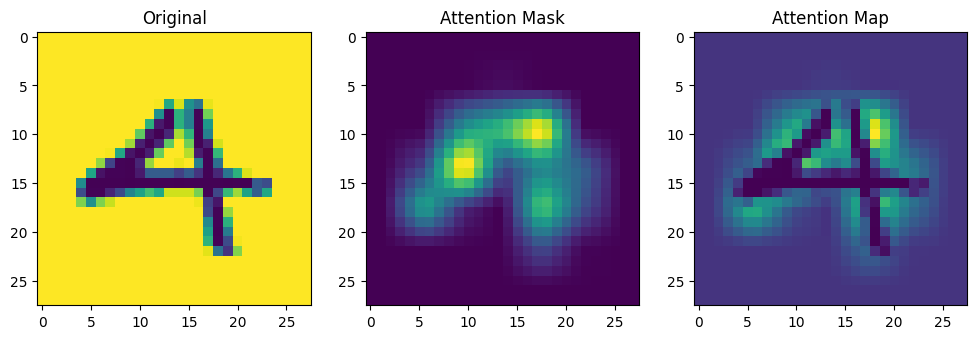

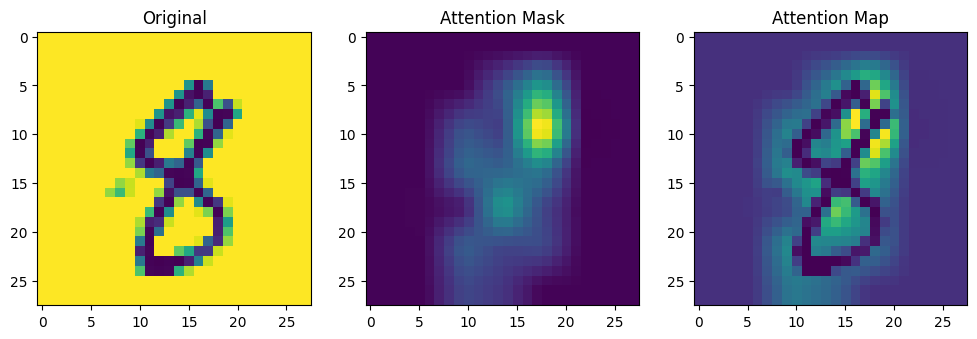

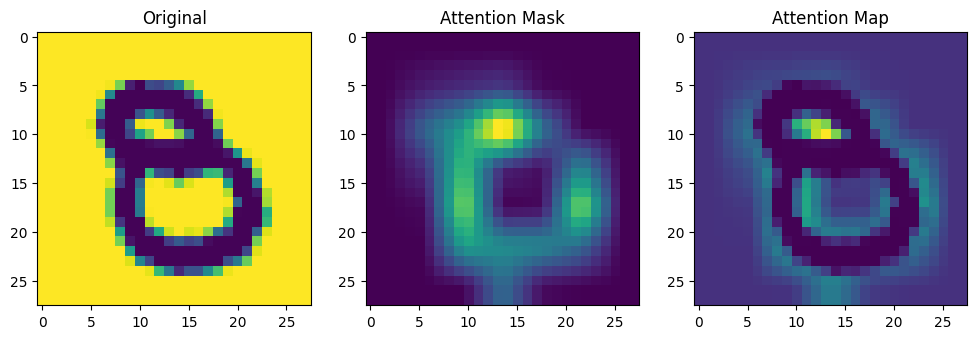

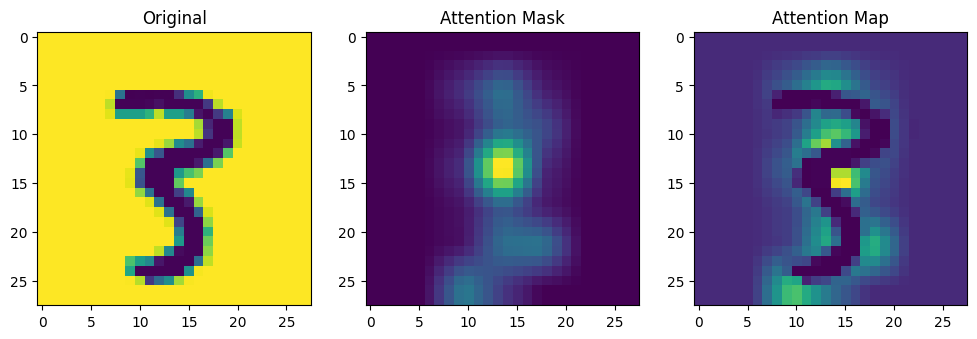

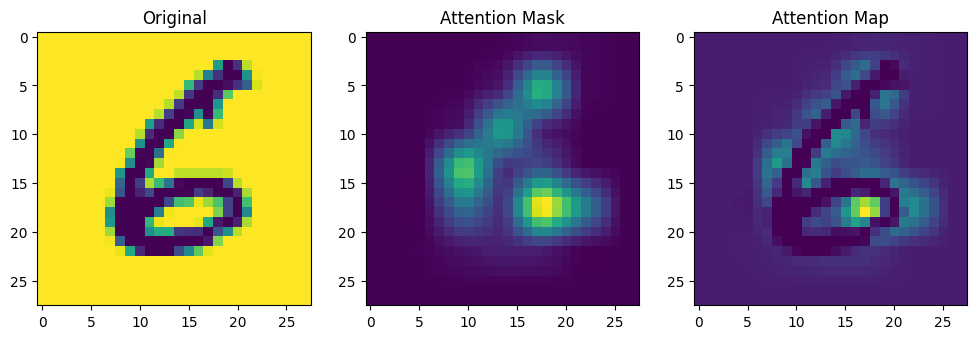

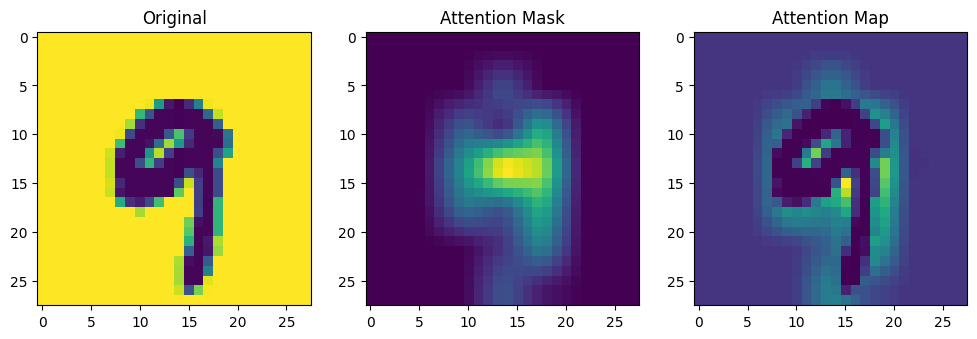

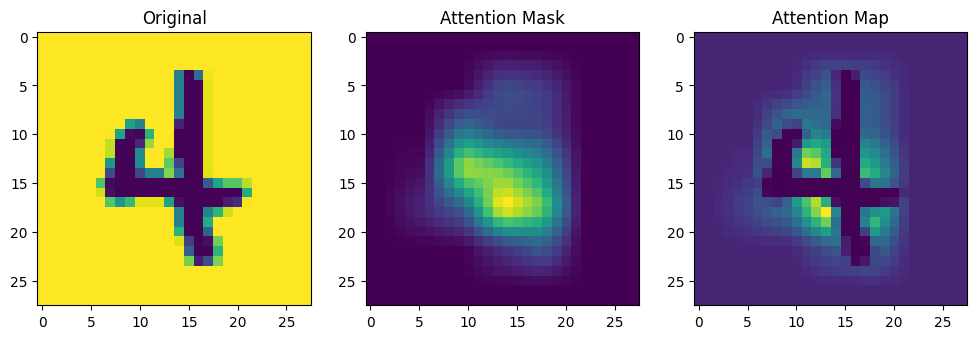

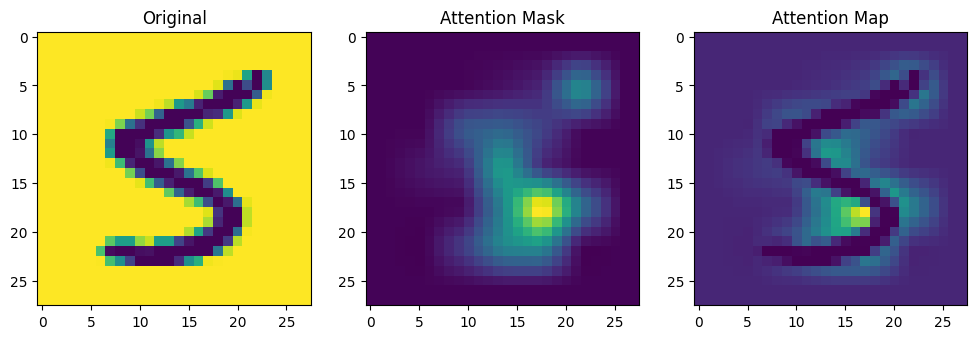

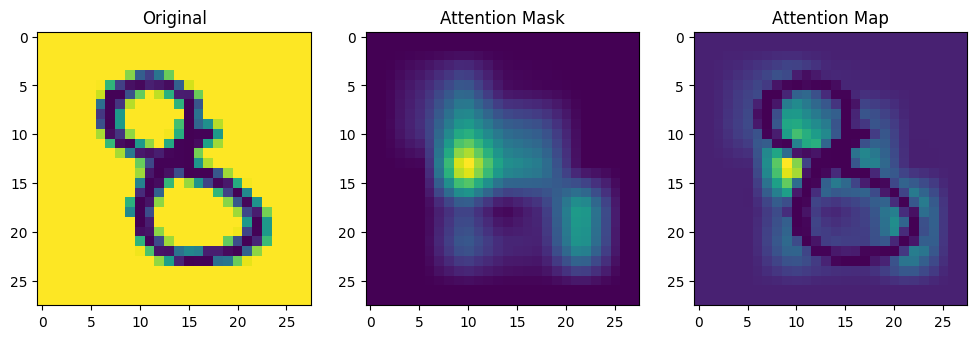

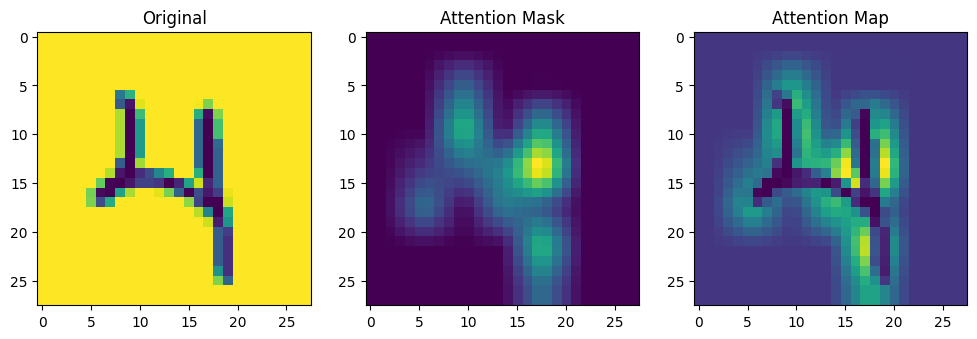

In [16]:
# reference : https://github.com/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb

import cv2

idxs = np.random.choice(range(len(mnist_test.data)), 10, False)
for idx in idxs:
  im = mnist_test.data[idx]  # [28,28]
  im = 255 - im # Image value inversion

  # Average the attention from the encoder over the head
  # [28,28] --> [1,1,28,28]
  _, attentions = model(im.unsqueeze(0).unsqueeze(1).to(device, torch.float))  # attentions: [(1,8,50,50)] * 12
  att_mat = torch.stack(attentions).squeeze(1)  # [12,1,8,50,50] --> [12.8.50.50]
  att_mat = att_mat.cpu().detach()

  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')  # [12,1,8,50,50] --> [12,50,50]

  residual_att = torch.eye(att_mat.size(1))  # [50,50]
  aug_att_mat = att_mat + residual_att  # [12,50,50]
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)  # [12,50,50]

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())  # [12,50,50]
  joint_attentions[0] = aug_att_mat[0]  # [50,50]

  for n in range(1, aug_att_mat.size(0)):
      # (50,50) @ (50,50) -> (50,50)
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

  # Attention from the output token to the input space.
  v = joint_attentions[-1]  # [50,50]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))  # sqrt(49) = 7
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()  # [7,7]
  mask = cv2.resize(mask / mask.max(), (im.shape[1], im.shape[0]))[..., np.newaxis]  # [28,28,1]
  result = (mask.squeeze() * im.numpy()).astype("uint8")  # [28,28]

  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(12, 12))

  ax1.set_title('Original')
  ax2.set_title('Attention Mask')
  ax3.set_title('Attention Map')
  _ = ax1.imshow(im)
  _ = ax2.imshow(mask.squeeze())
  _ = ax3.imshow(result)
